Here, we aim to tune a model that predicts participant's group based on resting-state connectivity.

Limitations:

- SVC scores highest but cannot be explained quickly by the SHAP explainers.
- Tree-based models perform poorly on the data but are fast to explain using SHAP.

In [219]:
%reload_ext autoreload
%autoreload 3
import math
import numpy as np
import xarray as xr
import pandas as pd

import skopt
from skopt.space import Real, Categorical, Integer

from sklearn import feature_selection, svm, preprocessing, model_selection, ensemble
from sklearn import decomposition, dummy
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set('paper')
import plotly.express as px
from tqdm import tqdm

import xgboost
import lightgbm

from python.acnets.datasets.connectivity import load_connectivity


In [255]:
X, y, feature_names = load_connectivity(
  parcellation='dosenbach2010',
  kind='tangent', # 'chatterjee' or 'precision'
  vectorize=True,
  return_y=True,
  only_diagonal=False,
  # binarization_threshold=1.0,
  return_feature_names=True,
  discard_diagonal=False,
  discard_cerebellum=False,)

# encode y as integers
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(y)

# test/train splits
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y,)

In [256]:
# Pipeline candidates
pipe = Pipeline([
  ('select', 'passthrough'),
  ('zerovar', 'passthrough'),
  ('reduce', 'passthrough'),
  ('model', dummy.DummyClassifier())
], verbose=False)


# parameter spaces

rfc_param_space = {
  'select': [
    feature_selection.SelectFromModel(svm.SVC(), max_features=50),
  ],
  'select__estimator__C': Real(.1, 10000, prior='log-uniform'),
  'select__estimator__gamma': Real(.1, 10, prior='log-uniform'),
  'select__estimator__degree': Integer(1,8),
  'select__estimator__kernel': Categorical(['linear']), #, 'poly', 'rbf']),
  'model': [
    ensemble.RandomForestClassifier(
      bootstrap=True, oob_score=True, warm_start=False, n_jobs=-1)
  ],
  # 'reduce__n_components': Real(0.9, .999),
  # 'reduce__whiten': Categorical([False, True]),
  'model__n_estimators': Integer(10, 1000),
  'model__criterion': Categorical(['entropy', 'gini']),
  'model__max_features': Categorical([None, 'sqrt', 'log2']),
  'model__max_depth': Integer(10, 100),
}

svc_param_space = {
  'reduce': ['passthrough'],
  'model': [
    svm.SVC(probability=True)
  ],
  'model__C': Real(.1, 10000, prior='log-uniform'),
  'model__gamma': Real(.1, 10, prior='log-uniform'),
  'model__degree': Integer(1,8),
  'model__kernel': Categorical(['linear']), #, 'poly', 'rbf']),
}


xgb_param_space = {
  'model': [
    xgboost.XGBClassifier(
      verbosity=0,
      use_label_encoder=False,
      objective='binary:logistic', eval_metric='auc')
  ],
  # 'model__colsample_bylevel': Real(.6, .7),
  # 'model__colsample_bytree': Real(.6, .7),
  'model__gamma': Real(0, 1),
  'model__learning_rate': Real(.0001, 1),
  # 'model__max_delta_step': Real(.1, 10),  
  'model__max_depth': Integer(4, 100),
  # 'model__min_child_weight': Integer(10, 500),
  'model__n_estimators': Integer(10, 100),
  # 'model__reg_alpha': Real(0, 1),
  # 'model__reg_lambda': Real(0, 1),
  # 'model__subsample': Real(.5, .8),
  # 'model__objective': ['binary:hinge', 'binary:logistic'],
  # 'model__tree_method': ['exact', 'hist'],
}

lgbm_param_space = {
  'model': Categorical([
    lightgbm.LGBMClassifier(metric='auc', objective='binary', n_jobs=-1)
  ]),
  'model__n_estimators': Integer(1,100),
  'model__min_child_samples': Integer(1,10),
  'model__max_depth': Integer(-1,10),
  'model__num_leaves': Integer(2, 10),
  # 'model__early_stopping_rounds': [30],
  # 'model__min_data_in_leaf': [30, 50, 100, 300, 400],
  'model__reg_alpha': Real(0, .5),
  'model__reg_lambda': Real(0, .5)
}

gbc_param_space = {
  'model': Categorical([
    ensemble.GradientBoostingClassifier()
  ]),
  'model__max_depth': Integer(1, 5),
  'model__learning_rate': Real(10e-5, 1, 'log-uniform'),
  # 'model__max_features': Integer(1, 30),
  'model__min_samples_split': Integer(2, 30),
  'model__min_samples_leaf': Integer(1, 16)
}

Now optimize hyper-parameters, and see how the model performs.

In [257]:
opt = skopt.BayesSearchCV(
    pipe,
    [(rfc_param_space, 64)],
    n_points=1,
    scoring='roc_auc',
    verbose=0,
)

progress_bar = tqdm(total=opt.total_iterations)

opt.fit(
    X[train], y[train], callback=[
      skopt.callbacks.DeadlineStopper(total_time=300),
      lambda _: False if progress_bar.update() else False,
    ]
)

progress_bar.close()

best_model = opt.best_estimator_.named_steps['model']

print('best params:', opt.best_params_)
print('train score:', opt.best_score_)
print('test  score:', opt.score(X[test], y[test]))

cv_scores = model_selection.cross_val_score(
    opt.best_estimator_, X, y, n_jobs=-1, scoring='roc_auc',
    cv=model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=20))

print(f'5-Fold AUC (20 repeats): {cv_scores.mean():.3f}'
      f' \N{plus-minus sign} {cv_scores.std():.3f}')


 59%|█████▉    | 38/64 [02:51<02:34,  5.95s/it]Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
 64%|██████▍   | 41/64 [03:03<01:50,  4.81s/it]Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
 91%|█████████ | 58/64 [04:51<00:30,  5.02s/it]


best params: OrderedDict([('model', RandomForestClassifier(criterion='entropy', max_depth=53, max_features='sqrt',
                       n_estimators=476, n_jobs=-1, oob_score=True)), ('model__criterion', 'entropy'), ('model__max_depth', 53), ('model__max_features', 'sqrt'), ('model__n_estimators', 476), ('select', SelectFromModel(estimator=SVC(C=340.6135315534693, degree=7,
                              gamma=0.1741899383689808, kernel='linear'),
                max_features=50)), ('select__estimator__C', 340.6135315534693), ('select__estimator__degree', 7), ('select__estimator__gamma', 0.1741899383689808), ('select__estimator__kernel', 'linear')])
train score: 0.9666666666666666
test  score: 1.0
5-Fold AUC (20 repeats): 0.858 ± 0.132


In [258]:
# print selected features ordered by importance

feature_selector = opt.best_estimator_.named_steps['select']
X_select = feature_selector.transform(X)
feature_names_sel = feature_names[feature_selector.get_support()]

rfc_importance_scores = opt.best_estimator_.named_steps['model'].feature_importances_

df = pd.DataFrame({
  'region': feature_names_sel,
  'rfc_importance': rfc_importance_scores
})
df.sort_values('rfc_importance', ascending=False)

,region,rfc_importance
45,post cingulate 111,0.080399
41,occipital 141 ↔ ACC 14,0.061850
39,occipital 137,0.060908
29,parietal 97 ↔ vlPFC 15,0.037930
35,precuneus 105,0.034568
46,IPS 134,0.033643
3,parietal 69 ↔ dFC 35,0.031438
38,occipital 92,0.030960
36,precuneus 94,0.028915
9,post occipital 153,0.027240


In [259]:
import shap

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
n_splits = cv.get_n_splits(X, y)

cv_shaps = []

from copy import deepcopy

model = opt.best_estimator_.named_steps['model']
print(model)

for cv_train, cv_test in tqdm(cv.split(X_select, y), total=n_splits):
  
  model.fit(X_select[cv_train], y[cv_train])

  explainer = shap.TreeExplainer(
    model, X_select[cv_train],
    feature_names=feature_names_sel)

  sh = explainer(X_select[cv_test], y[cv_test], check_additivity=False)
  cv_shaps.append(deepcopy(sh))


shap_values = shap.Explanation(
  values = np.vstack([sh.values[...,1] for sh in cv_shaps]),
  base_values = np.hstack([sh.base_values[...,1] for sh in cv_shaps]),
  data = np.vstack([sh.data for sh in cv_shaps]),
  feature_names=cv_shaps[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in cv_shaps]),
  output_names=y_encoder.classes_,
)

RandomForestClassifier(criterion='entropy', max_depth=53, max_features='sqrt',
                       n_estimators=476, n_jobs=-1, oob_score=True)


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


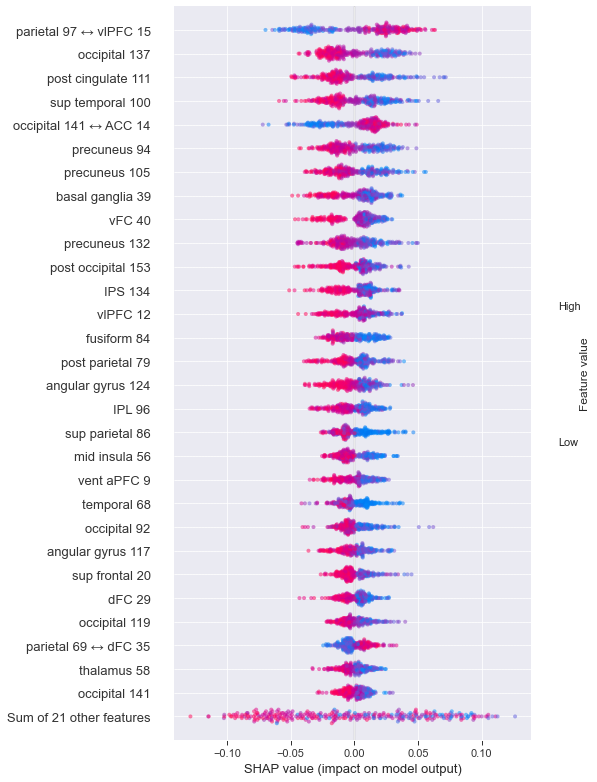

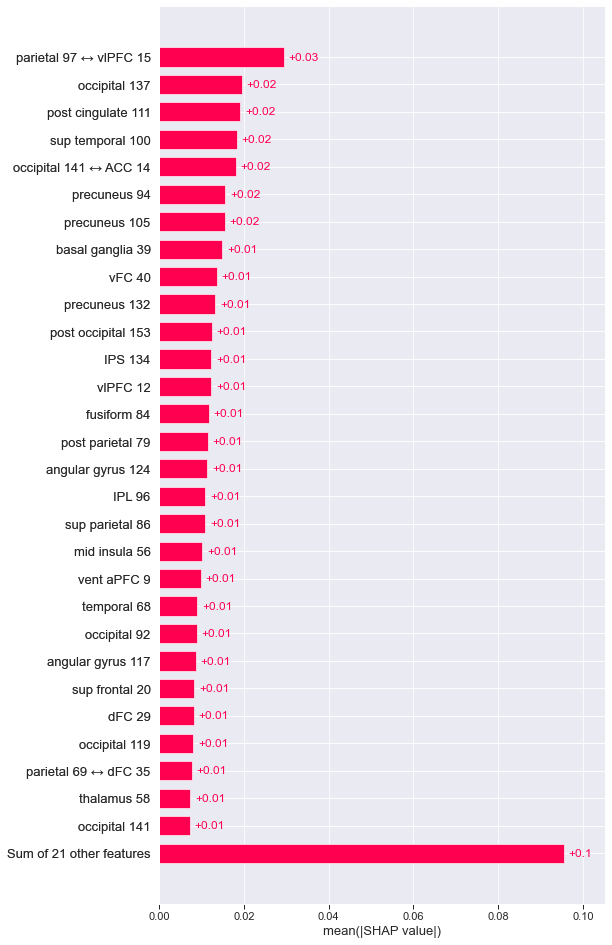

In [262]:

shap.plots.beeswarm(deepcopy(shap_values), alpha=.5, max_display=30)
shap.plots.bar(deepcopy(shap_values), max_display=30)